# Model comparison

In [1]:
import arviz as az
import numpy as np

import pymc as pm

print("PyMC version:", pm.__version__)

PyMC version: 5.22.0


In [2]:
az.style.use("arviz-darkgrid")

In [3]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

## Pooled model

In [11]:
with pm.Model() as pooled:
    # Latent pooled effect size
    mu = pm.Normal("mu", 0, sigma=1e6)

    obs = pm.Normal('obs', mu, sigma=sigma, observed=y)

    trace_p = pm.sample(2000, chains = 4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu]


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

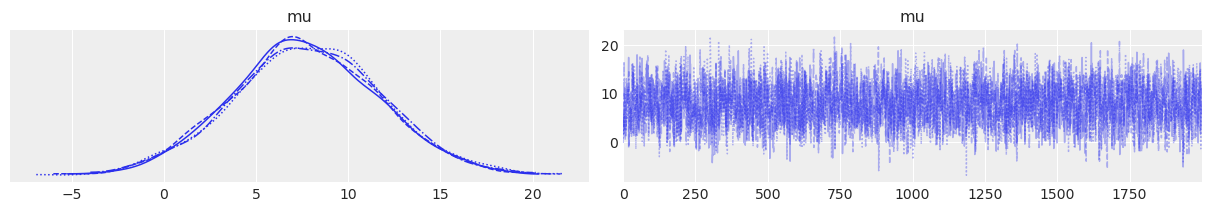

In [5]:
az.plot_trace(trace_p);

## Hierarchical model

In [8]:
with pm.Model() as hierarchical:
    eta = pm.Normal("eta", 0, 1, shape=J)
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)

    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma=sigma, observed=y)

    trace_h = pm.sample(2000, chains = 4, target_accept=0.90)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eta, mu, tau]


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


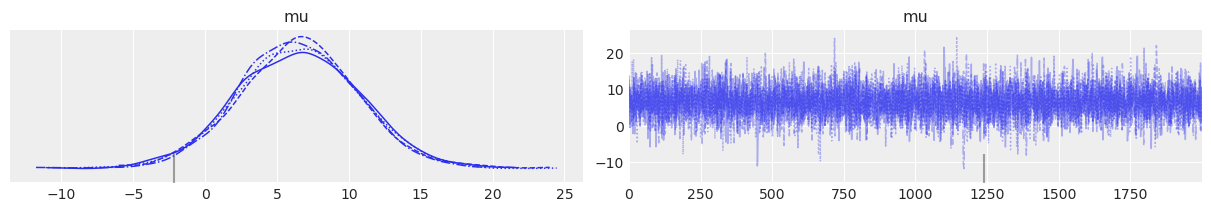

In [9]:
az.plot_trace(trace_h, var_names="mu");

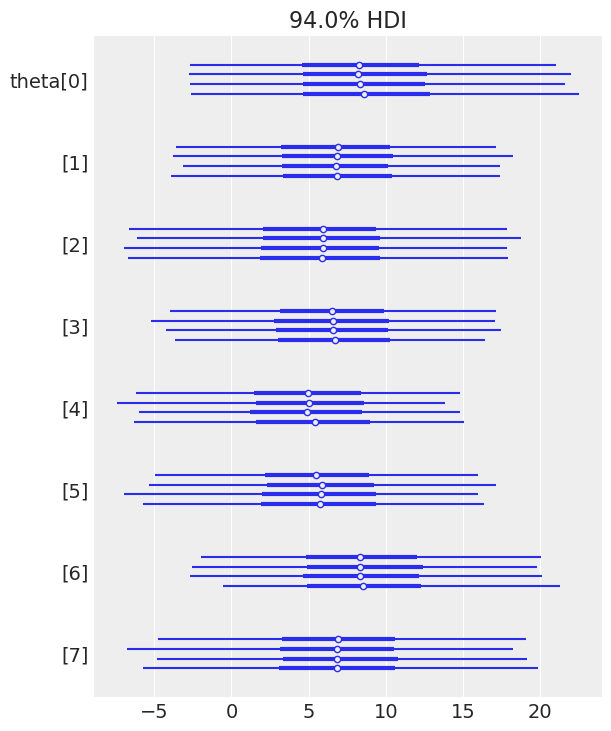

In [10]:
az.plot_forest(trace_h, var_names="theta");

## Model the log-likelihood

To compute Leave-one-out-CV (LOO) and WAIC (Widely-applicable Information Criterion), ArviZ needs the log-likelihood element-wise. We call a `pm` function within the `with model` frame to do that. It can also be done with

```python
idata_kwargs = {"log_likelihood": True}
```

within the `sample` function. 

In [12]:
with pooled:
    pm.compute_log_likelihood(trace_p)

/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [13]:
pooled_loo = az.loo(trace_p)

pooled_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.56     1.11
p_loo        0.67        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        8  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
with hierarchical:
    pm.compute_log_likelihood(trace_h)

/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [15]:
hierarchical_loo = az.loo(trace_h)

hierarchical_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.79     1.07
p_loo        1.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        8  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

ArviZ includes two convenience functions to help compare LOO for different models. The first of these functions is `compare`, which computes LOO (or WAIC) from a set of traces and models and returns a DataFrame.

In [16]:
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.555661,0.669177,0.000000,1.000000e+00,1.107125,0.000000,False,log
hierarchical,1,-30.792834,1.148522,0.237172,2.220446e-16,1.070384,0.232531,False,log


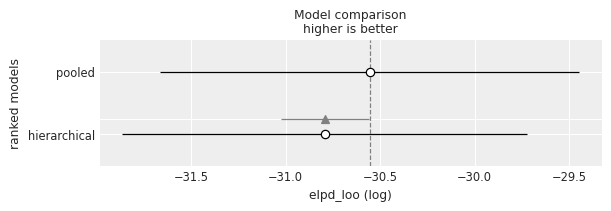

In [18]:
az.plot_compare(df_comp_loo, insample_dev=False, plot_ic_diff=True);

## Interpretation

Though we might expect the hierarchical model to outperform a complete pooling model, there is little to choose between the models in this case, given that both models gives very similar values of the information criteria. This is more clearly appreciated when we take into account the uncertainty (in terms of standard errors) of LOO and WAIC.